# Inference

In [1]:
# imports
import ast
import os
import pathlib

import neptune
import numpy as np
import torch
from torch.utils.data import DataLoader
from torchvision.models.detection.transform import GeneralizedRCNNTransform
from dotenv import load_dotenv

from custom_dataset import ObjectDetectionDataSet, ObjectDetectionDatasetSingle, ObjectDetectionDataSetDouble
from detection.faster_RCNN import get_fasterRCNN_resnet
from detection.transformations import ComposeDouble, ComposeSingle
from detection.transformations import FunctionWrapperDouble, FunctionWrapperSingle
from detection.transformations import apply_nms, apply_score_threshold, normalize_01
from detection.utils import get_filenames_of_path, collate_single, save_json

/anaconda/envs/azureml_py38/lib/python3.8/site-packages/pytorch_lightning/metrics/__init__.py:43: LightningDeprecationWarning: `pytorch_lightning.metrics.*` module has been renamed to `torchmetrics.*` and split off to its own package (https://github.com/PyTorchLightning/metrics) since v1.3 and will be removed in v1.5
  rank_zero_deprecation(


In [2]:
# parameters
params = {'EXPERIMENT': 'BAL-11',  # experiment name, e.g. BAL-11
          'OWNER': 'feid',  # e.g. johndoe55
          'INPUT_DIR': 'dataset/balloon/val',  # files to predict
          'PREDICTIONS_PATH': 'balloon/predictions',  # where to save the predictions
          'MODEL_DIR': 'balloon/BAL-11/checkpoints/epoch=96-step=3006.ckpt',  # load model from checkpoint
          'DOWNLOAD': False,  # whether to download from neptune
          'DOWNLOAD_PATH': 'model',  # where to save the model if DOWNLOAD is True
          'PROJECT': 'Balloon',  # Project name
          }

In [3]:
# input files
inputs = get_filenames_of_path(pathlib.Path(params['INPUT_DIR']))
inputs = [f for f in inputs if f.suffix == '.jpg']
inputs.sort()

In [4]:
# transformations
transforms = ComposeSingle([
    FunctionWrapperSingle(np.moveaxis, source=-1, destination=0),
    FunctionWrapperSingle(normalize_01)
])

In [5]:
# create dataset
dataset = ObjectDetectionDatasetSingle(inputs=inputs,
                                       transform=transforms,
                                       use_cache=False,
                                       )

In [6]:
# create dataloader
dataloader_prediction = DataLoader(dataset=dataset,
                                   batch_size=1,
                                   shuffle=False,
                                   num_workers=0,
                                   collate_fn=collate_single)

In [7]:
load_dotenv() # read environment variables in the notebook
api_key = os.environ['NEPTUNE']  # if this throws an error, you probably didn't set your env var
project_name = f'{params["OWNER"]}/{params["PROJECT"]}'
project = neptune.init(project_qualified_name=project_name, api_token=api_key)  # get project
experiment_id = params['EXPERIMENT']  # experiment id
experiment = project.get_experiments(id=experiment_id)[0]
parameters = experiment.get_parameters()
properties = experiment.get_properties()

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

plt.rcParams["savefig.bbox"] = 'tight'

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

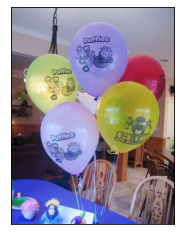

In [9]:
from torchvision.utils import make_grid

# view dataset
sample = dataset[10]
grid = make_grid(sample['x'])
show(grid)

In [10]:
# download model from neptune or load from checkpoint
if params['DOWNLOAD']:
    download_path = pathlib.Path(os.getcwd()) / params['DOWNLOAD_PATH']
    download_path.mkdir(parents=True, exist_ok=True)
    model_name = 'best_model.pt'  # that's how I called the best model
    # model_name = properties['checkpoint_name']  # logged when called log_model_neptune()
    if not (download_path / model_name).is_file():
        experiment.download_artifact(path=model_name, destination_dir=download_path)  # download model

    model_state_dict = torch.load(download_path / model_name)
else:
    checkpoint = torch.load(params['MODEL_DIR'], map_location="cpu")
    model_state_dict = checkpoint['hyper_parameters']['model'].state_dict()

In [11]:
# model init
model = get_fasterRCNN_resnet(num_classes=int(parameters['CLASSES']),
                              backbone_name=parameters['BACKBONE'],
                              anchor_size=ast.literal_eval(parameters['ANCHOR_SIZE']),
                              aspect_ratios=ast.literal_eval(parameters['ASPECT_RATIOS']),
                              fpn=ast.literal_eval(parameters['FPN']),
                              min_size=int(parameters['MIN_SIZE']),
                              max_size=int(parameters['MAX_SIZE'])
                              )

In [12]:
# load weights
model.load_state_dict(model_state_dict)

<All keys matched successfully>

In [13]:
# inference (cpu)
model.eval()
for sample in dataloader_prediction:
    x, x_name = sample
    with torch.no_grad():
        pred = model(x)
        pred = {key: value.numpy() for key, value in pred[0].items()}
        name = pathlib.Path(x_name[0])
        save_dir = pathlib.Path(os.getcwd()) / params['PREDICTIONS_PATH']
        save_dir.mkdir(parents=True, exist_ok=True)
        pred_list = {key: value.tolist() for key, value in pred.items()}  # numpy arrays are not serializable -> .tolist()
        save_json(pred_list, path=save_dir / name.with_suffix('.json'))

In [14]:
# get prediction files
predictions = get_filenames_of_path(pathlib.Path(os.getcwd()) / params['PREDICTIONS_PATH'])
predictions.sort()

In [17]:
# create prediction dataset
iou_threshold = 0.25
score_threshold = 0.6

# Experiment with Non-maximum suppression (nms) and score-thresholding
transforms_prediction = ComposeDouble([
    FunctionWrapperDouble(np.moveaxis, source=-1, destination=0),
    #FunctionWrapperDouble(normalize_01),
    FunctionWrapperDouble(apply_nms, input=False, target=True, iou_threshold=iou_threshold),
    FunctionWrapperDouble(apply_score_threshold, input=False, target=True, score_threshold=score_threshold)
])

dataset_prediction = ObjectDetectionDataSetDouble(inputs=inputs,
                                            targets=predictions,
                                            transform=transforms_prediction,
                                            use_cache=False)

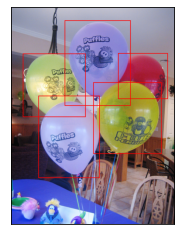

In [22]:
from torchvision.utils import make_grid, draw_bounding_boxes
pred = dataset_prediction[10]
bboxes = draw_bounding_boxes(pred['x'].to(torch.uint8), pred['y']['boxes'], colors=["red"]*len(pred['y']['boxes']), width=3)
show(bboxes) 